In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.reparam import LocScaleReparam
from pyro.contrib.examples.bart import load_bart_od

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:, :, dataset["stations"].index("EMBR")].log1p()
print(data.shape)

torch.Size([78888, 50])


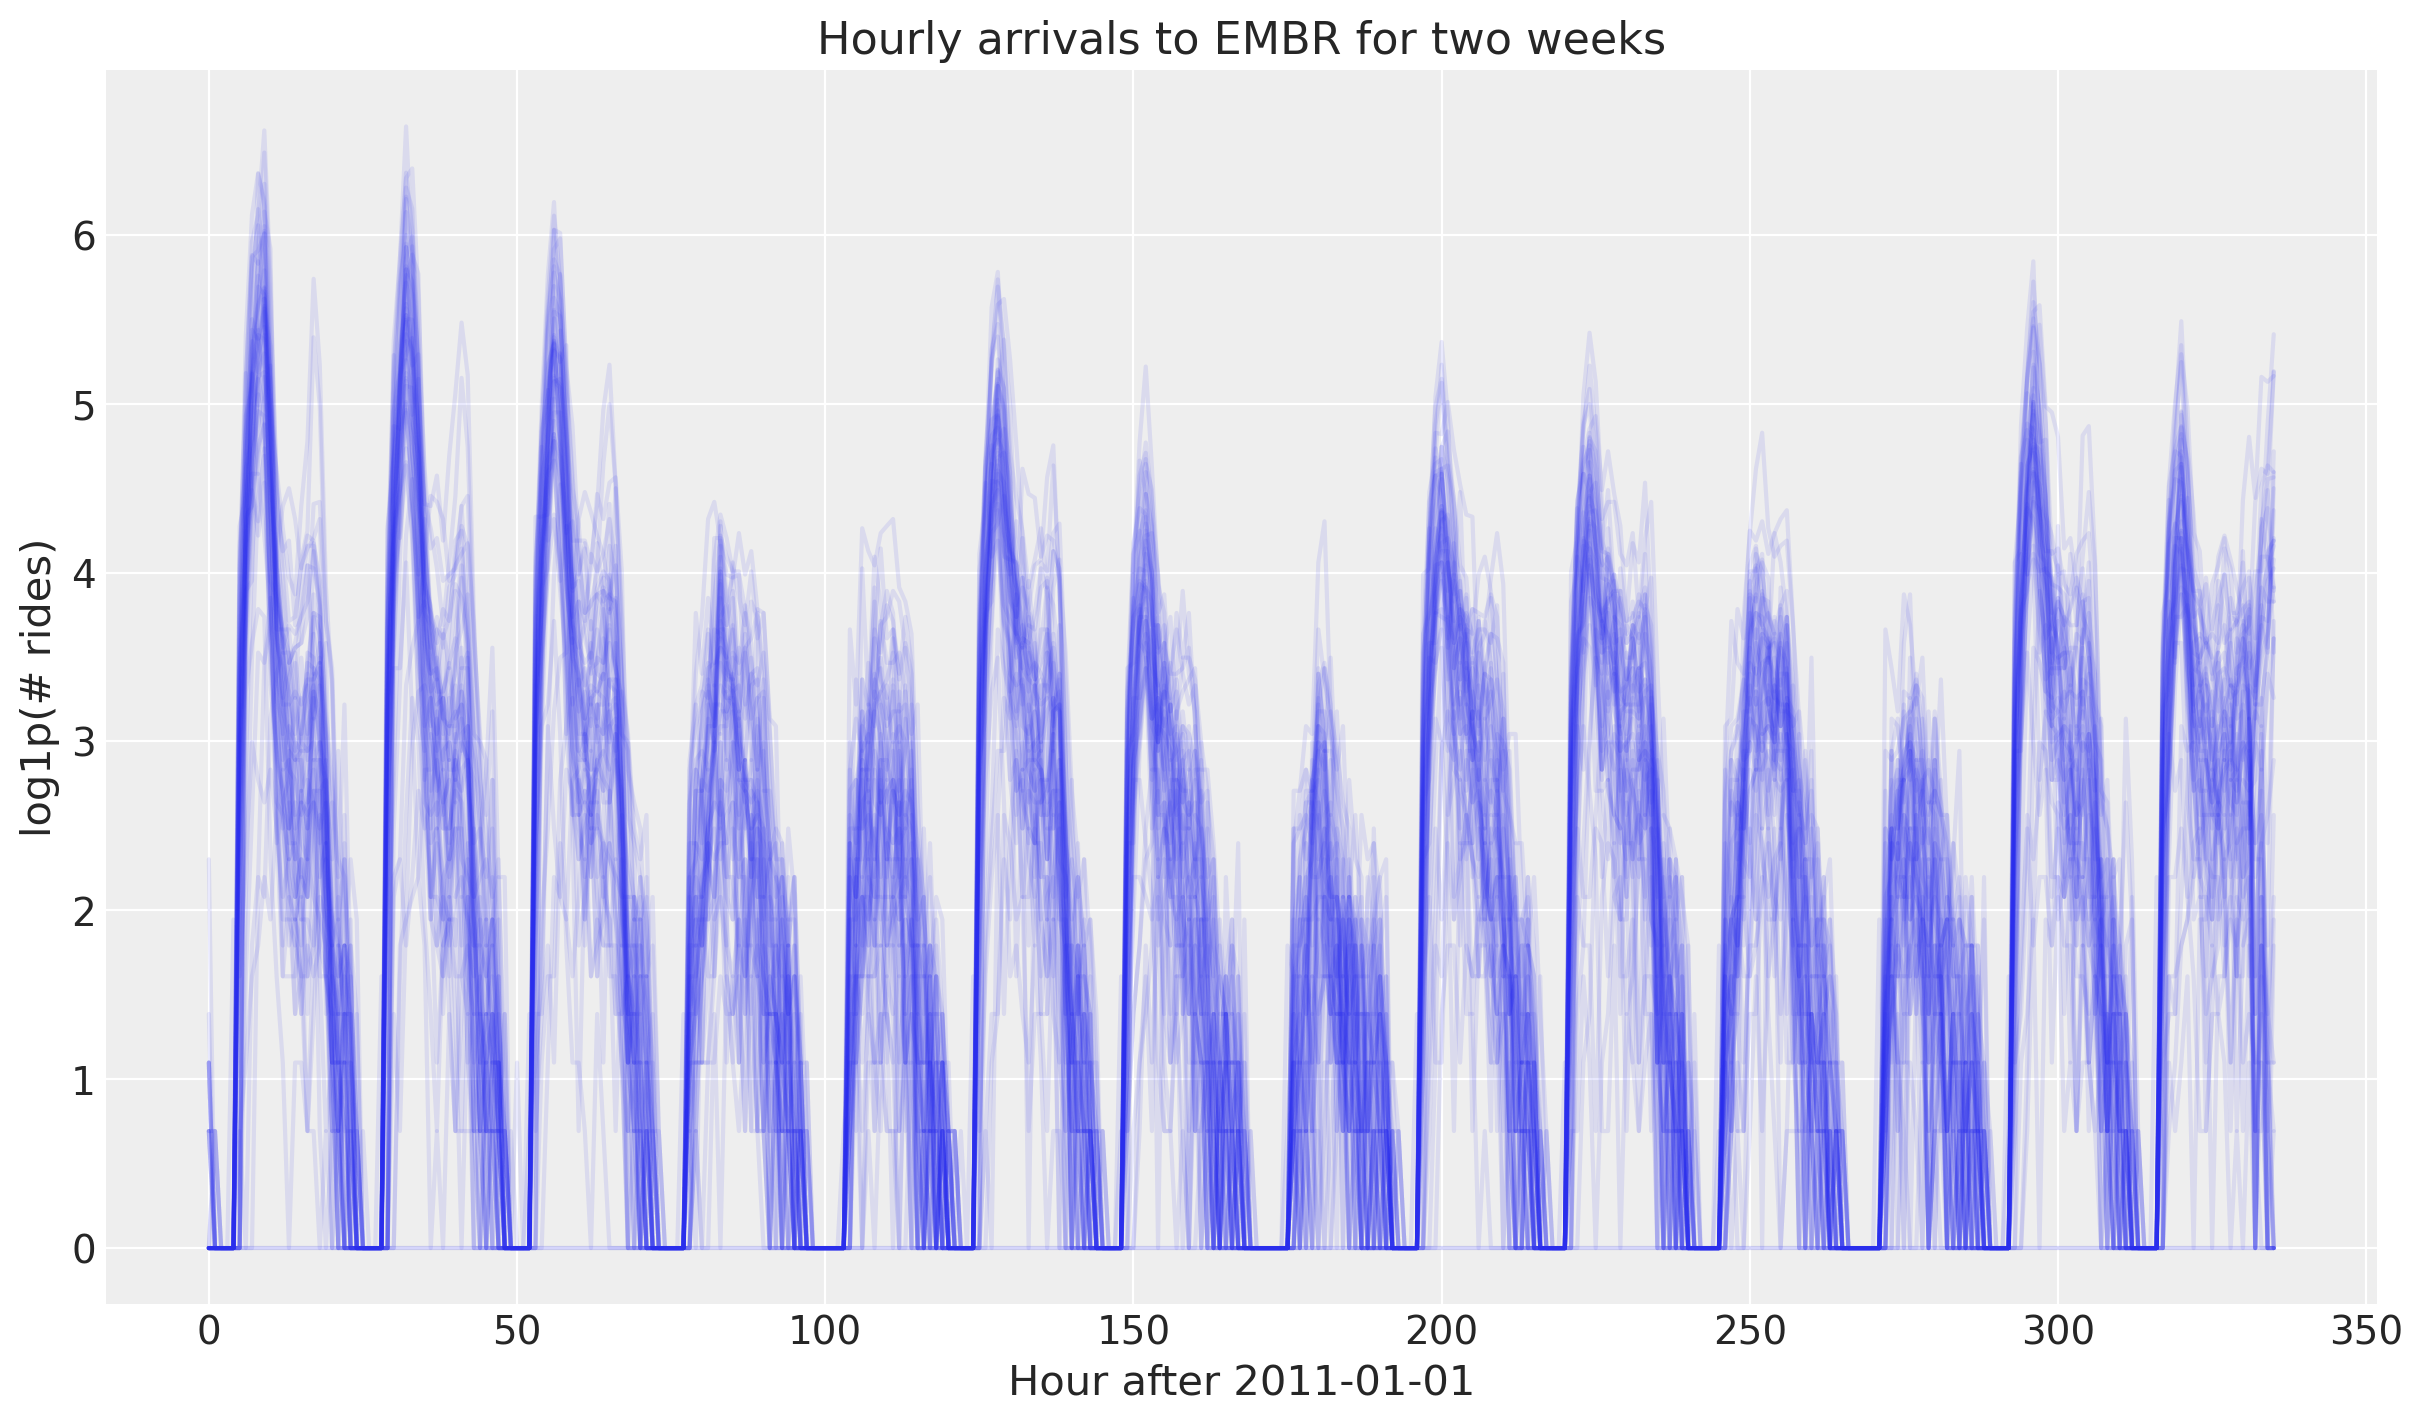

In [4]:
fig, ax = plt.subplots()
ax.plot(data[-24 * 7 * 2 :], "-", c="C0", alpha=0.1, markeredgewidth=0)
ax.set(
    title="Hourly arrivals to EMBR for two weeks",
    ylabel="log1p(# rides)",
    xlabel="Hour after 2011-01-01",
);

In [5]:
T2 = data.size(-2)  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [6]:
y = jnp.array(data[T0:T2])
y_train = jnp.array(data[T0:T1])
y_test = jnp.array(data[T1:T2])

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (2496, 50)
y_train: (2160, 50)
y_test: (336, 50)


In [7]:
n_stations = y_train.shape[-1]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

assert time_train.size + time_test.size == time.size
assert y_train.shape == (t_max_train, n_stations)
assert y_test.shape == (t_max_test, n_stations)

In [8]:
covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

In [9]:
def model(
    covariates: Float[Array, "t_max n_series"],
    y: Float[Array, "t_max n_series"] | None = None,
) -> None:
    t_max, n_series = covariates.shape
    # Get the time and feature dimensions

    # Global scale for the drift
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-20, scale=5))

    # Degrees of freedom for the Student-T distribution
    nu = numpyro.sample("nu", dist.Gamma(concentration=10, rate=2))
    # Scale for the Student-T distribution
    sigma = numpyro.sample("sigma", dist.LogNormal(loc=-5, scale=5))

    centered = numpyro.sample("centered", dist.Uniform(low=0, high=1))

    with (
        numpyro.plate("n_series", n_series),
        numpyro.plate("time", t_max),
        numpyro.handlers.reparam(config={"drift": LocScaleReparam(centered=centered)}),
    ):
        drift = numpyro.sample("drift", dist.Normal(loc=0, scale=drift_scale))

    def transition_fn(carry, t):
        "Local level transition function"
        previous_level = carry
        current_level = previous_level + drift[t]
        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # Compute the mean of the model
    mu = pred_levels

    print(mu.shape)

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.StudentT(df=nu, loc=mu, scale=sigma))

(2160, 50)
(2160, 50)


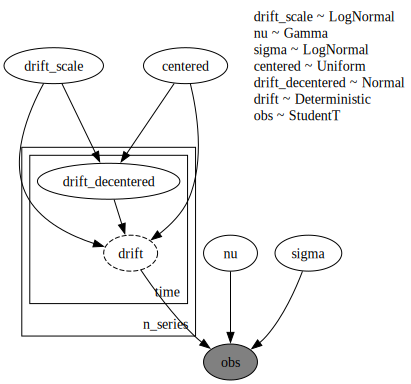

In [10]:
numpyro.render_model(
    model=model,
    model_kwargs={"covariates": covariates_train, "y": y_train},
    render_distributions=True,
    render_params=True,
)

In [11]:
prior_predictive = Predictive(model=model, num_samples=2_000, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(rng_subkey, covariates_train)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={"time_train": time_train, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time_train", "n_series"]},
)

(2160, 50)


In [12]:
idata_prior

Inference data with groups:
	> prior_predictive

(2160, 50)
(2160, 50)
(2160, 50)


  0%|          | 0/5000 [00:00<?, ?it/s]

(2160, 50)


100%|██████████| 5000/5000 [00:13<00:00, 369.03it/s, init loss: 890371.2500, avg. loss [4751-5000]: 217555.7770]


CPU times: user 26.9 s, sys: 9.12 s, total: 36 s
Wall time: 15.8 s


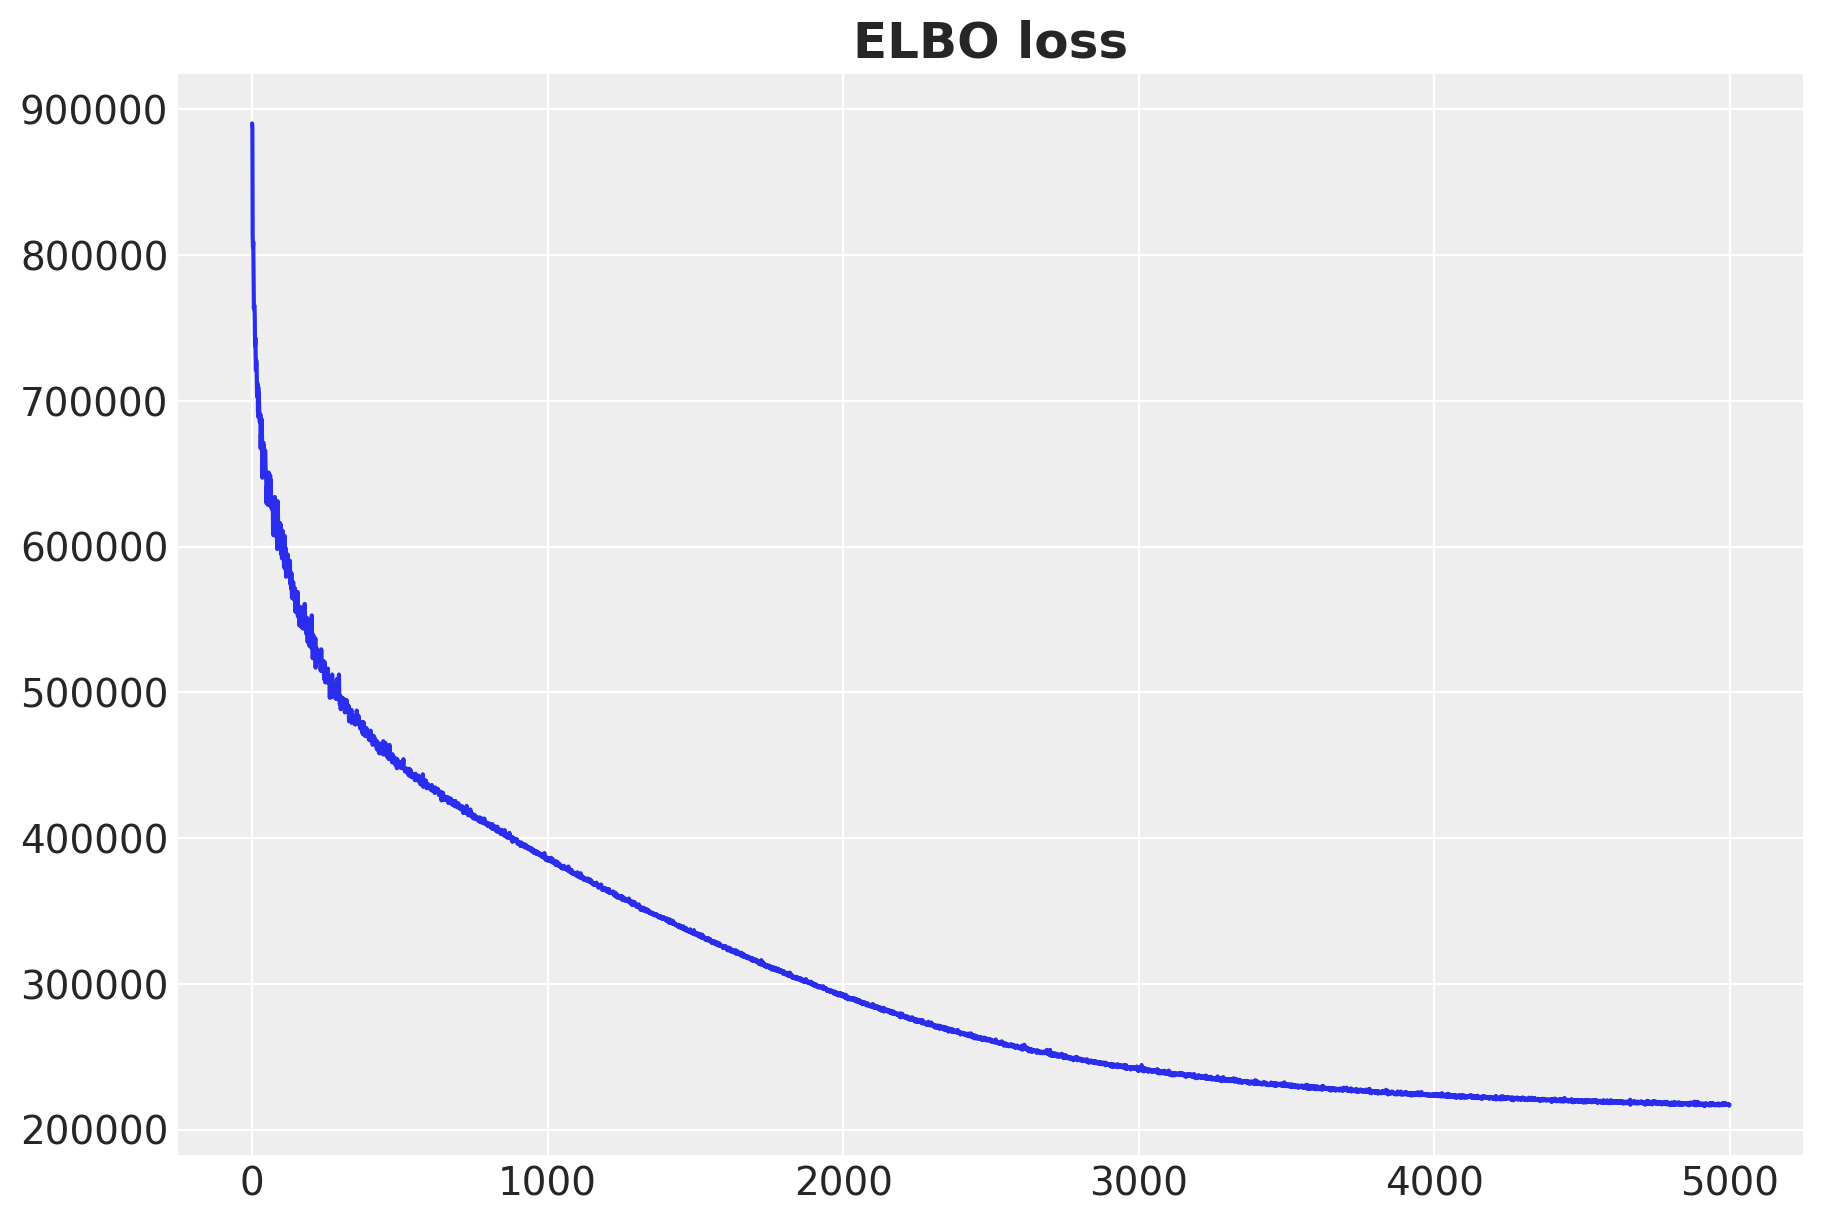

In [13]:
%%time

guide = AutoNormal(model)
optimizer = numpyro.optim.Adam(step_size=0.005)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
num_steps = 5_000

rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set_title("ELBO loss", fontsize=18, fontweight="bold");

In [14]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=2_000,
    return_sites=["obs"],
)

In [15]:
covariates_train.shape

(2160, 50)

In [16]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates_train).items()
    },
    coords={"time_train": time_train, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time_train", "n_series"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...] for k, v in posterior(rng_subkey, covariates).items()
    },
    coords={"time": time, "n_series": jnp.arange(n_stations)},
    dims={"obs": ["time", "n_series"]},
)

(2160, 50)
(2496, 50)


Text(0.5, 0.98, 'Posterior predictive checks')

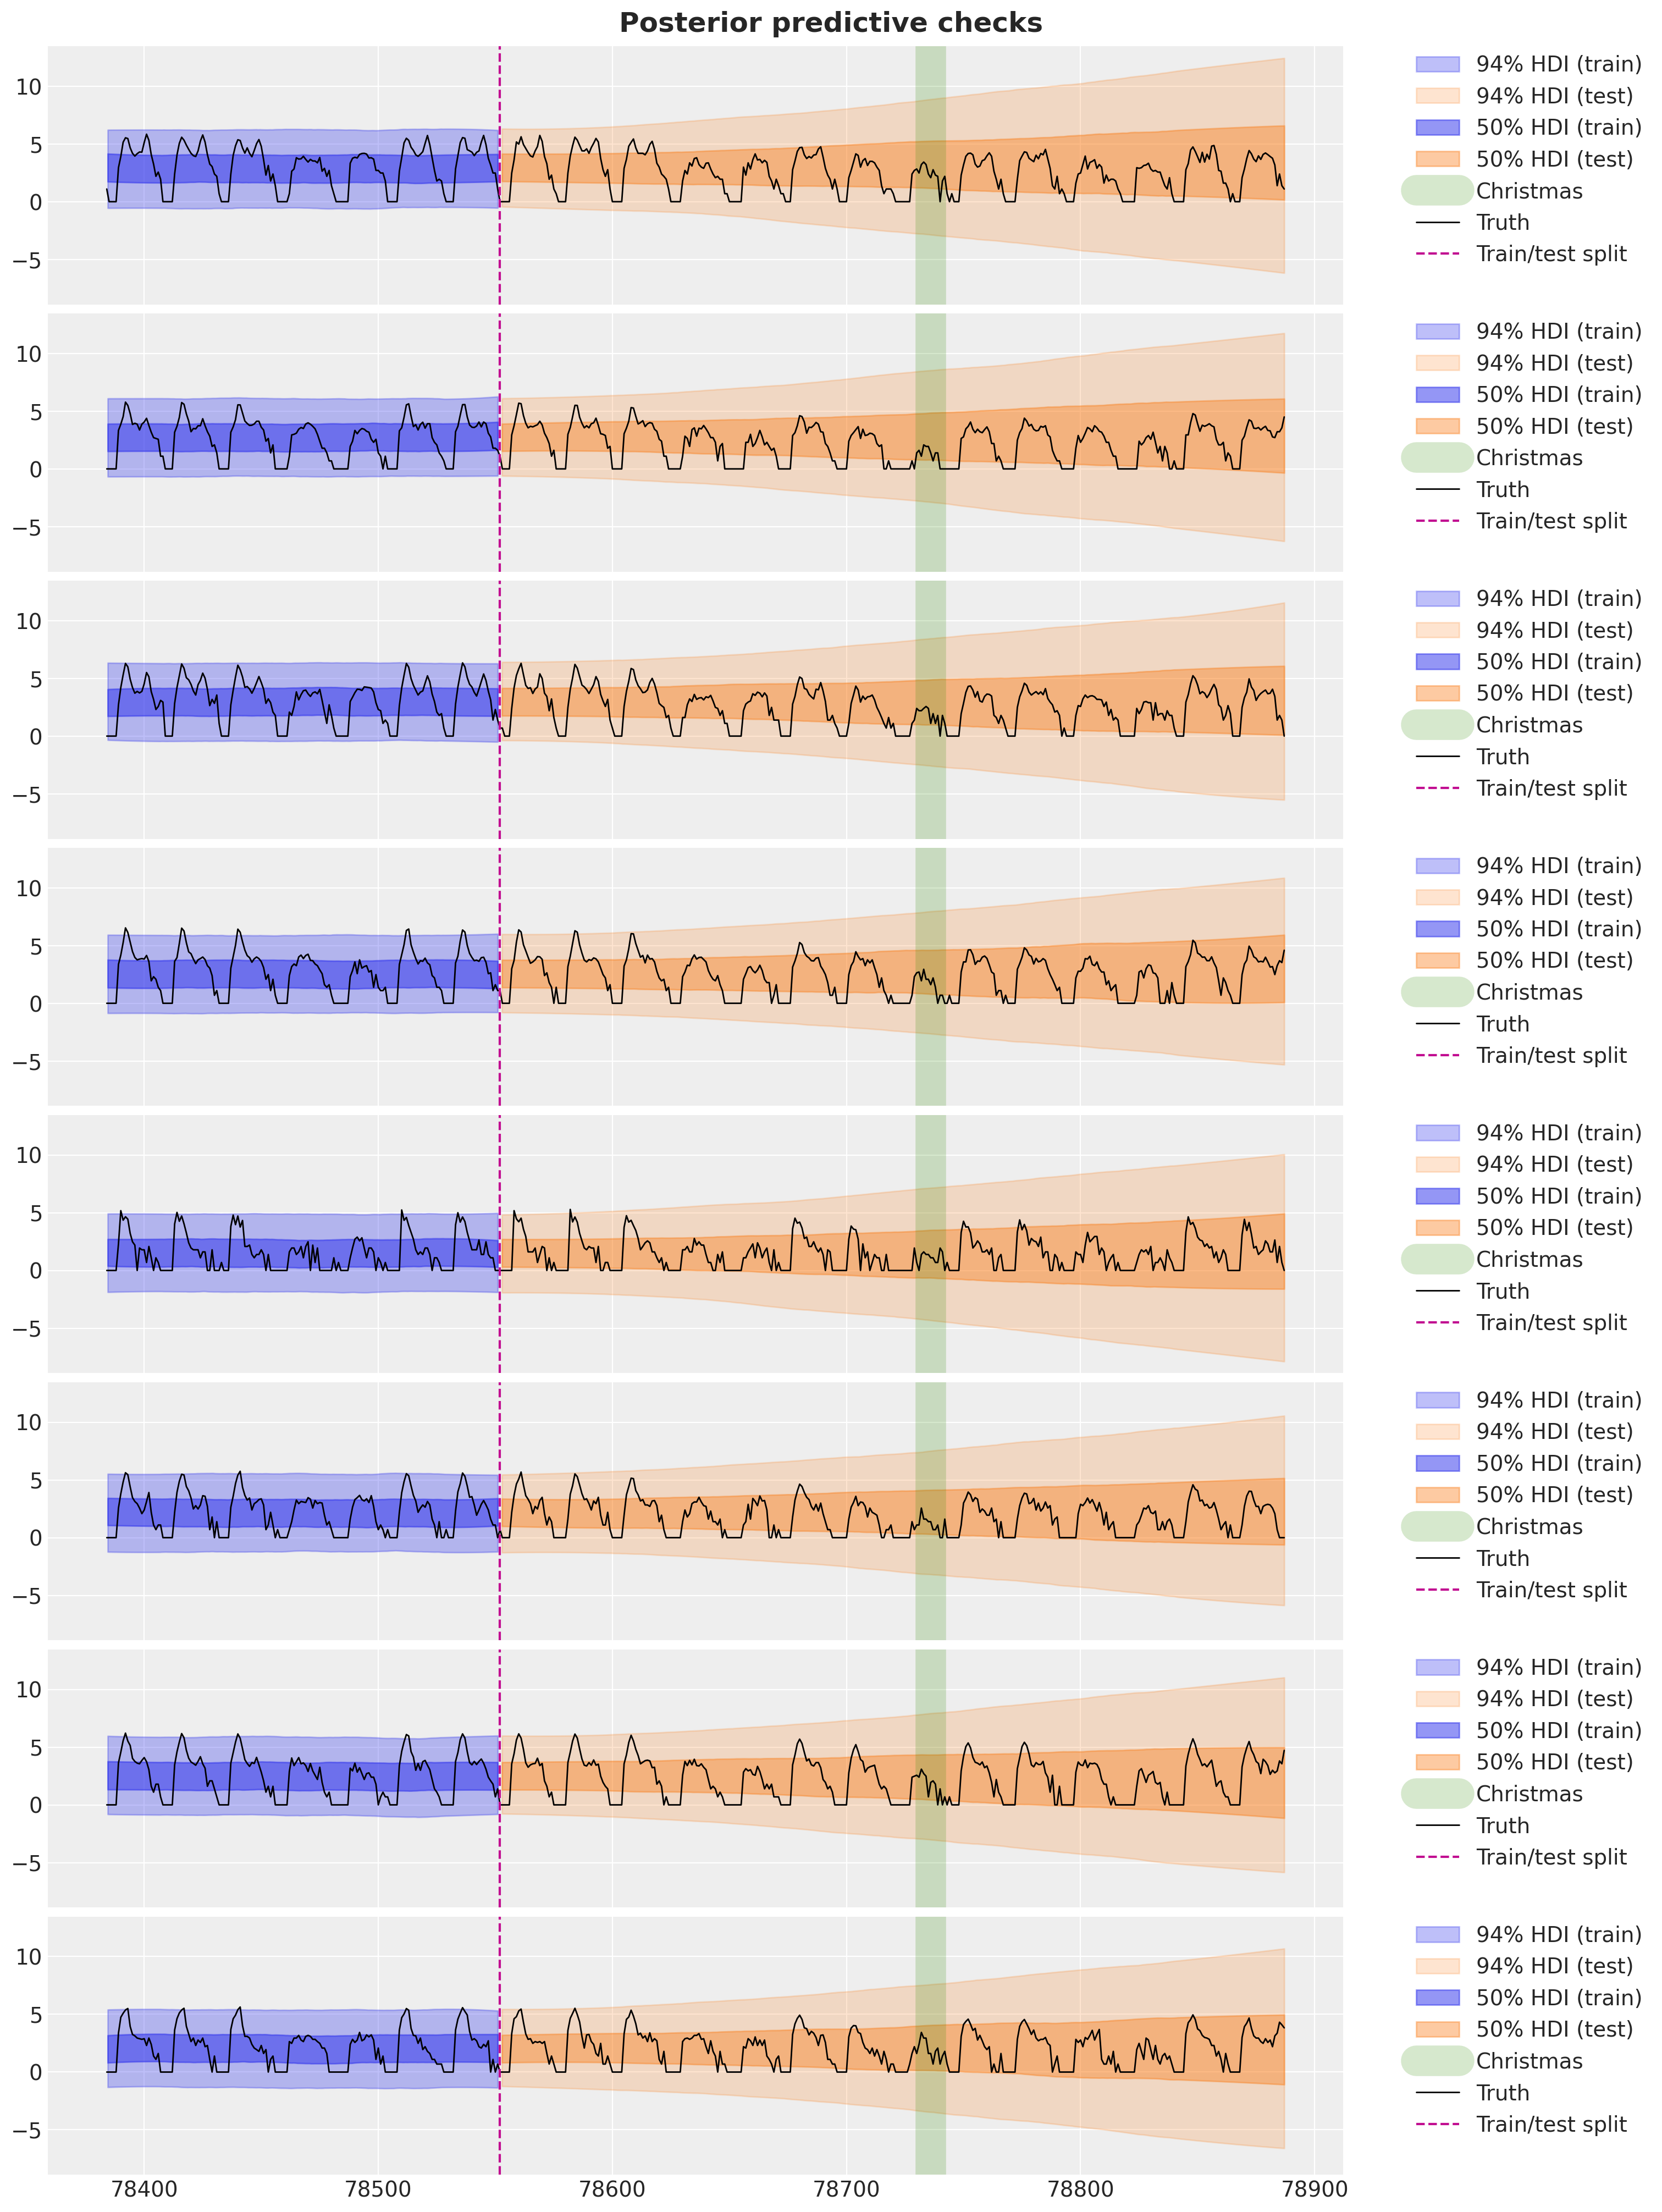

In [35]:
fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 20), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"].sel(n_series=i)[
                :, :, time_train >= T1 - 24 * 7
            ],
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (train)",
            },
            ax=ax,
        )
        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"].sel(n_series=i)[:, :, time >= T1],
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob*100:.0f}% HDI (test)",
            },
            ax=ax,
        )
    ax.axvline(78736, color="C2", lw=20, alpha=0.2, label="Christmas")
    ax.plot(
        time[time >= T1 - 24 * 7],
        data[T1 - 24 * 7 : T2, i],
        "black",
        lw=1,
        label="Truth",
    )
    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

fig.suptitle("Posterior predictive checks", fontsize=18, fontweight="bold")